# TVID 2

Bonzi Théo IMAGE 2024

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from tqdm import tqdm

In [65]:
def load_images(img1_path, img2_path):
    F1 = Image.open(img1_path, mode='r', formats=None)
    F2 = Image.open(img2_path, mode='r', formats=None)
    F1_grey = Image.open(img1_path, mode='r', formats=None).convert('L')
    F2_grey = Image.open(img2_path, mode='r', formats=None).convert('L')

    return F1, F2, F1_grey, F2_grey

In [66]:
dir_path = './data/'
img_1 = os.path.join(dir_path, 'LF052.jpg')
img_2 = os.path.join(dir_path, 'LF054.jpg')

F1, F2, F1_grey, F2_grey = load_images(img1_path=img_1, img2_path=img_2)

In [67]:
def plot_images(img1, img2, title_1='Image 1', title_2="Image 2"):
    plt.figure(figsize=(20, 20))
    
    plt.subplot(1, 2, 1)
    plt.title(title_1)
    plt.imshow(img1)
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.title(title_2)
    plt.imshow(img2)
    plt.axis('off')

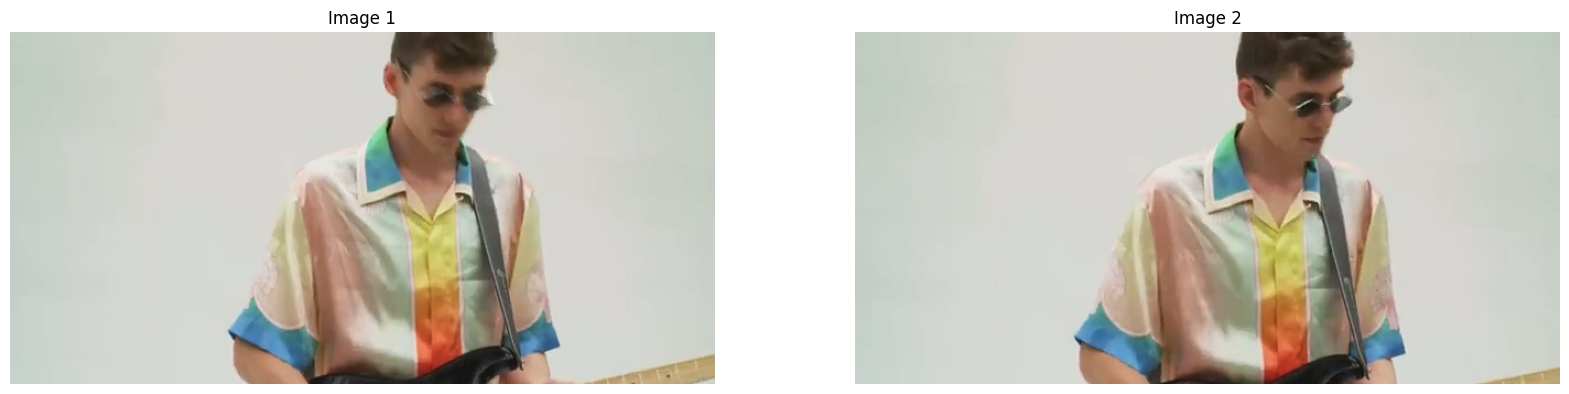

In [68]:
plot_images(F1, F2)

In [69]:
def image_to_float(img_1, img_2, img_grey_1, img_grey_2):
    f1 = np.asarray(img_1)
    f2 = np.asarray(img_2)
    f1_grey = np.asarray(img_grey_1) / 255
    f2_grey = np.asarray(img_grey_2) / 255
    
    return f1, f2, f1_grey, f2_grey

f1, f2, f1_grey, f2_grey = image_to_float(img_1=F1, img_2=F2, img_grey_1=F1_grey, img_grey_2=F2_grey)

# Backward_motion_estimation

In [70]:
def backward_motion_estimation(F1, F2, block_size):
    print(f"Block: {block_size}")
    F1_array = np.asarray(F1)
    F2_array = np.asarray(F2)

    height, width = F2_array.shape[:2]
    motion_vectors = np.zeros((height // block_size, width // block_size, 2), dtype=int)

    for y in tqdm(range(0, height, block_size), desc="Backward motion"):
        for x in range(0, width, block_size):
            best_match = (0, 0)
            min_diff = float('inf')

            F2_block = F2_array[y:y+block_size, x:x+block_size]

            for y1 in range(max(0, y - block_size), min(height - block_size, y + block_size)):
                for x1 in range(max(0, x - block_size), min(width - block_size, x + block_size)):
                    F1_block = F1_array[y1:y1+block_size, x1:x1+block_size]
                    diff = np.sum(np.abs(F2_block - F1_block))

                    if diff < min_diff:
                        min_diff = diff
                        best_match = (x1 - x, y1 - y)

            motion_vectors[y // block_size, x // block_size] = best_match

    return motion_vectors

# Reconstruct image

In [71]:
def reconstruct_image(F1, motion_vectors, block_size):
    F1_array = np.asarray(F1)
    height, width = F1_array.shape[:2]
    reconstructed = np.zeros_like(F1_array)

    for y in tqdm(range(0, height, block_size), desc="Reconstruct image"):
        for x in range(0, width, block_size):
            dx, dy = motion_vectors[y // block_size, x // block_size]
            reconstructed[y:y+block_size, x:x+block_size] = F1_array[y+dy:y+dy+block_size, x+dx:x+dx+block_size]

    return reconstructed

# MSE

In [72]:
def calculate_mse(original, reconstructed):
    mse = np.mean((original - reconstructed) ** 2)
    return mse

Block: 2


Reconstruct image: 100%|██████████| 160/160 [00:00<00:00, 1078.44it/s]


MSE: 22.7071875


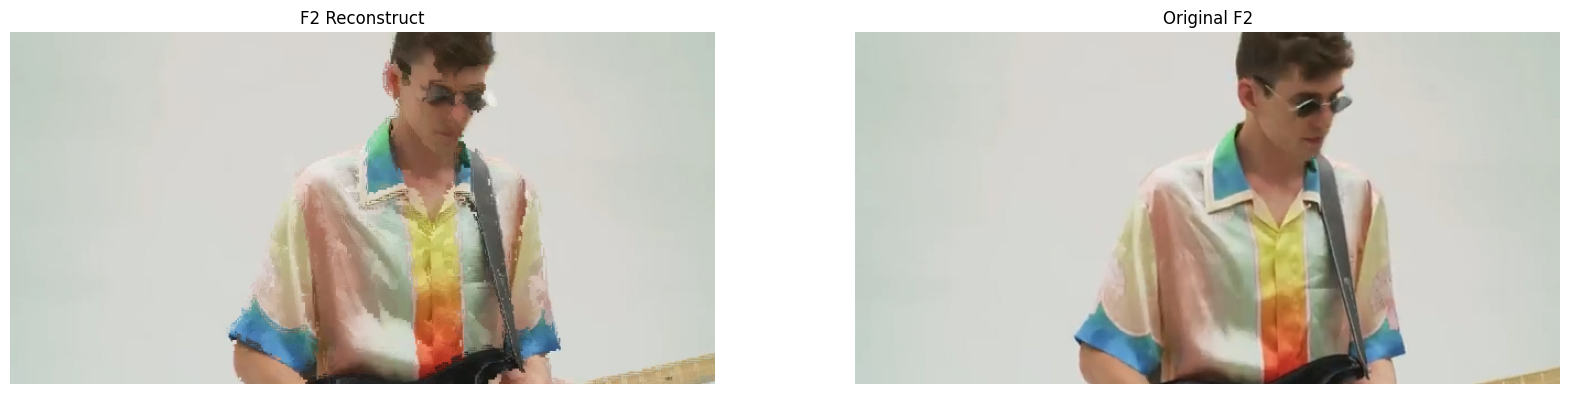

Block: 4


Reconstruct image: 100%|██████████| 80/80 [00:00<00:00, 1961.04it/s]


MSE: 23.055555013020832


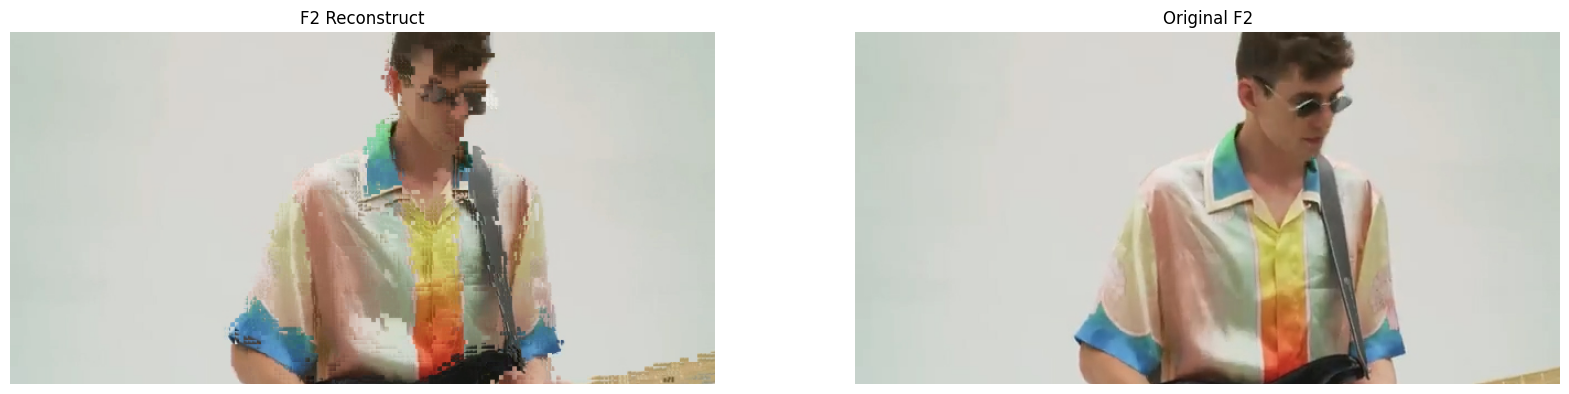

Block: 8


Reconstruct image: 100%|██████████| 40/40 [00:00<00:00, 4381.05it/s]


MSE: 25.273430989583332


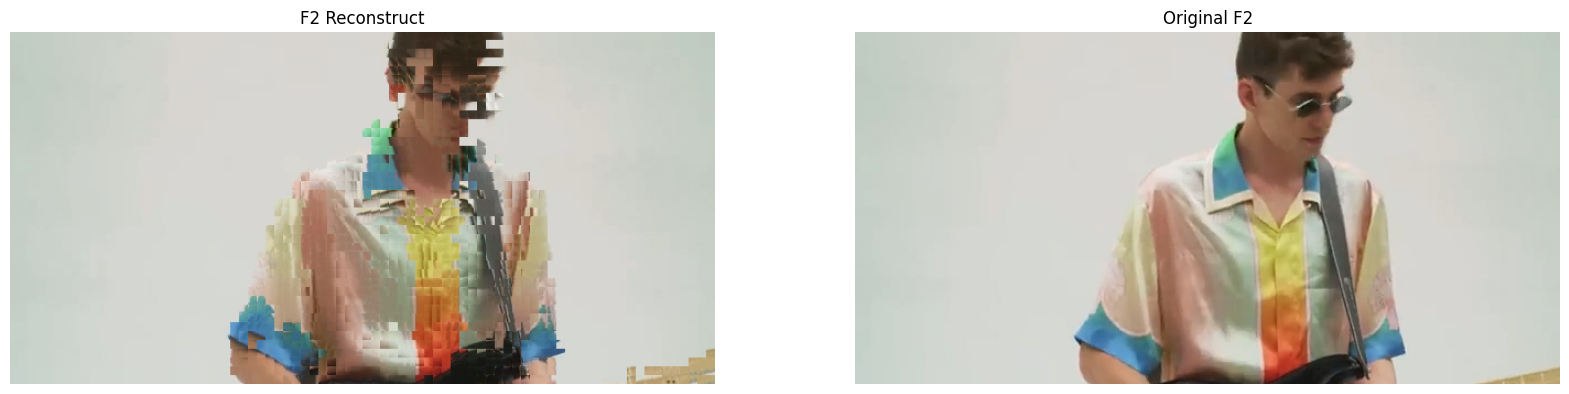

Block: 16


Reconstruct image: 100%|██████████| 20/20 [00:00<00:00, 6723.26it/s]


MSE: 29.587091471354167


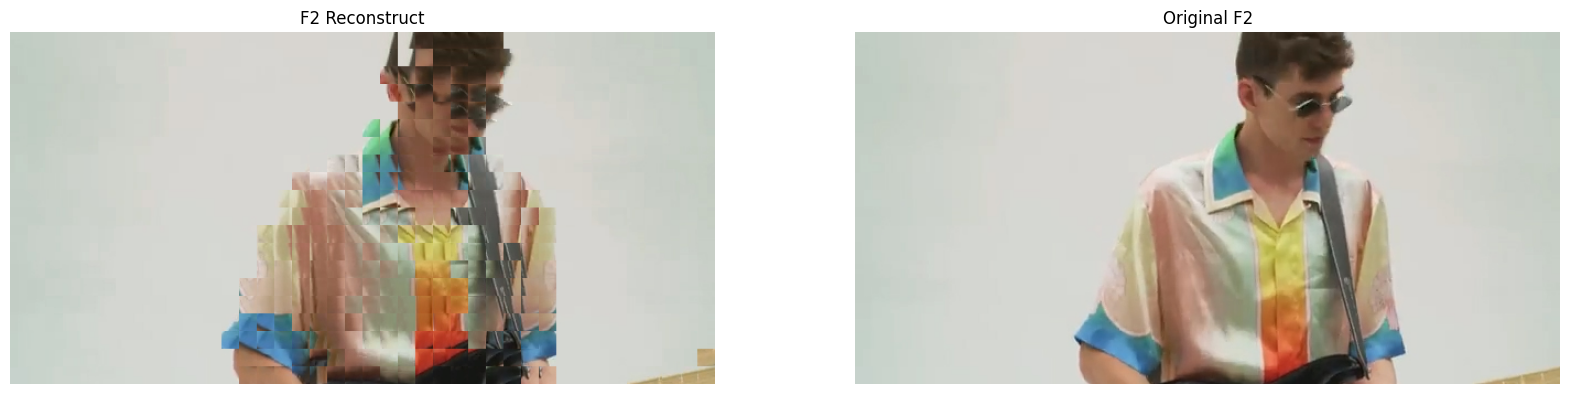

In [73]:
block_sizes = [2, 4, 8, 16]

for block in block_sizes:
    motion_vectors = backward_motion_estimation(F1, F2, block)
    F2_reconstructed = reconstruct_image(F1, motion_vectors, block)
    mse = calculate_mse(np.asarray(F2), F2_reconstructed)
    print(f"MSE: {mse}")
    plot_images(F2_reconstructed, F2, title_1="F2 Reconstruct",title_2="Original F2")
    plt.show()

# (B)

L'avantage de l'estimation backward est que nous essayons de prédire F1 à partir de F2. Cela est particulièrement efficace si de nouveaux objets sont révélés dans F1. En effet, la méthode forward repose sur l'hypothèse que les objets et la scène se déplacent de manière uniforme entre les frames.

Or si un nouvel objet apparaît dans F2, l'image reconstruite aura alors des artefacts.

L'estimation backward permet de gérer ce problème, il utilise l'image future pour prédire l'ancienne, sachant l'image suivante, il est plus facile de reconstruire l'image précédente.

# (C)

Pour reconstruire l'image F2, nous avons besoin des 3 données classiques suivantes :
- Le Vecteurs de Mouvement (motion_vectors)
- L'image de référence (F1)
- Les différences résiduelles entre F2 reconstruite et l'originale F2

In [74]:
def calculate_residuals(original, reconstructed):
    return original - reconstructed

Block: 8


Reconstruct image: 100%|██████████| 40/40 [00:00<00:00, 2806.77it/s]


MSE après reconstruction avec résiduels:  0.0


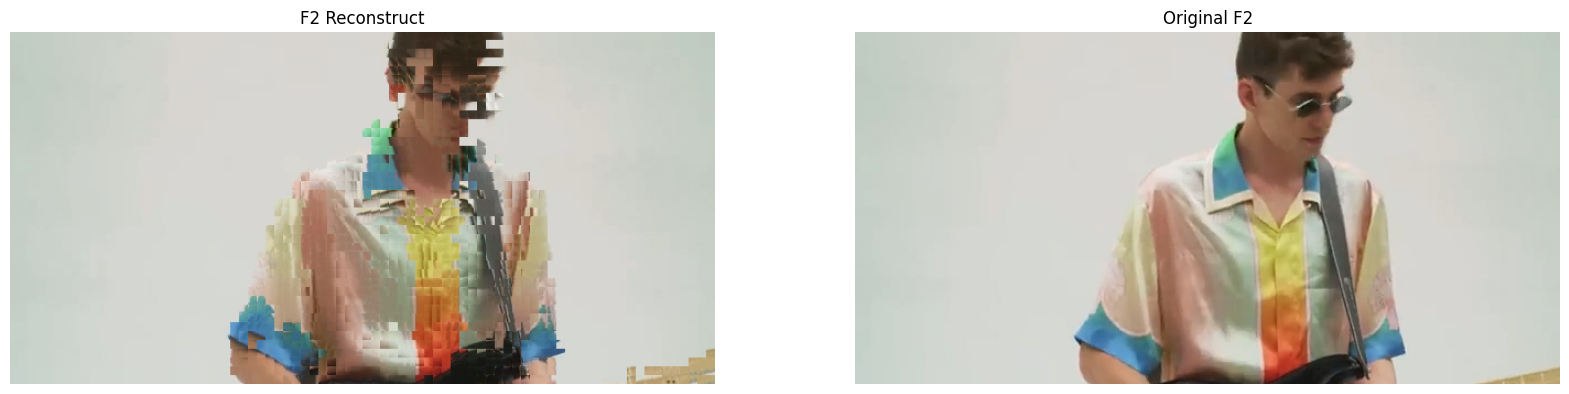

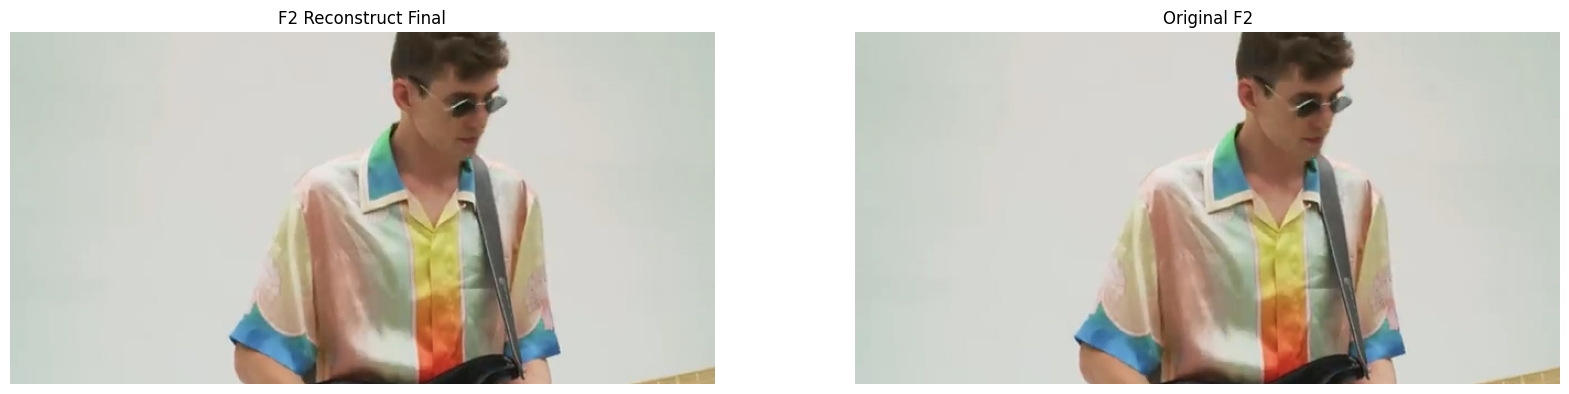

In [75]:
block_size = 8

# 1. Calcul des vecteurs de mouvement
motion_vectors = backward_motion_estimation(F1, F2, block_size)

# 2. Reconstruction de F2 à partir des vecteurs de mouvement
F2_reconstructed = reconstruct_image(F1, motion_vectors, block_size)

plot_images(F2_reconstructed, F2, title_1="F2 Reconstruct",title_2="Original F2")

# 3. Calcul des résiduels
residuals = calculate_residuals(np.asarray(F2), F2_reconstructed)

# 3 données classiques: F1, motion_vectors, residuals --> F2

# 4. Reconstruction finale de F2 avec les différences résiduelles
F2_final_reconstruction = F2_reconstructed + residuals

# Calcul de la MSE
mse = calculate_mse(np.asarray(F2), F2_final_reconstruction)
print("MSE après reconstruction avec résiduels: ", mse)

plot_images(F2_final_reconstruction, F2, title_1="F2 Reconstruct Final",title_2="Original F2")

# (E)

Après avoir utilisé les 3 données "classiques", nous avons maintenant une MSE de 0.

# (F)

Nous pouvons coder avec perte les différences résiduelles. Nous pouvons réduire la taille des données de la différence.

In [76]:
def calculate_residuals_with_loss(original, reconstructed, quantization_level):
    residuals = original - reconstructed
    residuals_quantified = np.round(residuals / quantization_level) * quantization_level
    return residuals_quantified

Block: 8


Reconstruct image: 100%|██████████| 40/40 [00:00<00:00, 5062.68it/s]


MSE après reconstruction avec résiduels:  0.00046642246972318345


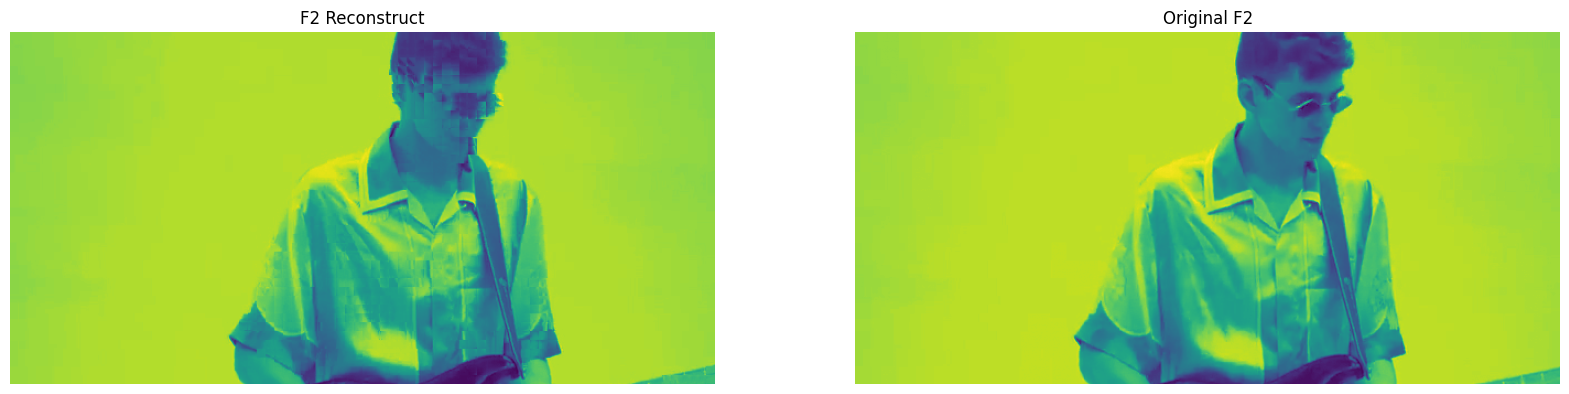

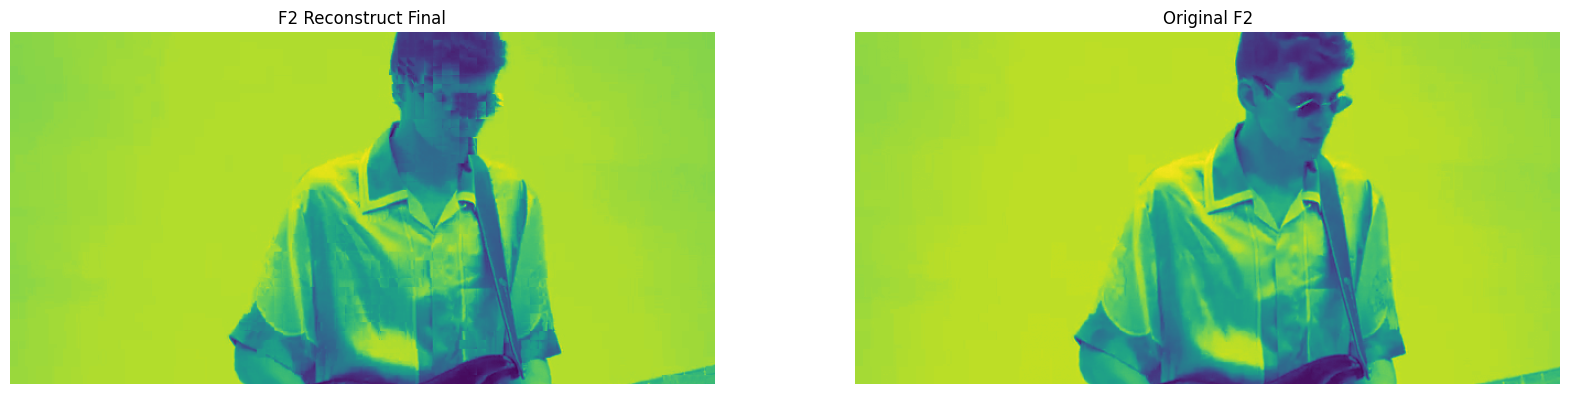

In [80]:
block_size = 8

# 1. Calcul des vecteurs de mouvement
motion_vectors = backward_motion_estimation(f1_grey, f2_grey, block_size)

# 2. Reconstruction de F2 à partir des vecteurs de mouvement
F2_reconstructed = reconstruct_image(f1_grey, motion_vectors, block_size)

plot_images(F2_reconstructed, f2_grey, title_1="F2 Reconstruct",title_2="Original F2")

# 3. Calcul des résiduels avec perte
residuals = calculate_residuals_with_loss(f2_grey, F2_reconstructed, 10)

# 4. Reconstruction finale de F2 avec les différences résiduelles
F2_final_reconstruction = F2_reconstructed + residuals

F2_final_reconstruction = np.clip(F2_final_reconstruction, 0, 255)

# Calcul de la MSE
mse = calculate_mse(f2_grey, F2_final_reconstruction)
print("MSE après reconstruction avec résiduels: ", mse)

plot_images(F2_final_reconstruction, f2_grey, title_1="F2 Reconstruct Final",title_2="Original F2")